In [42]:
import os
import cv2
import numpy as np

In [43]:
class LvsNoL():
    img_size=100
    lShape="l-shape"
    Nolshape="no-l-shape"
    Labels = { lShape:1, Nolshape:0 }
    training_data=[]
    failed=0
    def make_training_data(self):
        for label in self.Labels:
            print(label)
            for f in os.listdir(label):
                try:
                    path=os.path.join(label,f)
                    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img=cv2.resize(img,(self.img_size,self.img_size))
                    self.training_data.append([np.array(img),np.eye(2)[self.Labels[label]]])
                except:
                    self.failed+=1

        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)

lvsnol=LvsNoL()
lvsnol.make_training_data()

l-shape
no-l-shape


In [44]:
training_data=np.load("training_data.npy",allow_pickle=True)

In [45]:
print(len(training_data))

1113


[0. 1.]


<function matplotlib.pyplot.show(close=None, block=None)>

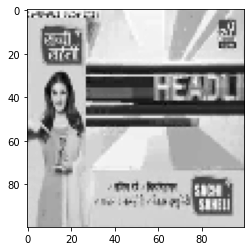

In [46]:
import matplotlib.pyplot as plt
plt.imshow(training_data[19][0],cmap="gray")
print(training_data[19][1])
plt.show

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,32,5)
        self.conv2=nn.Conv2d(32,64,5)
        self.conv3=nn.Conv2d(64,128,5)
        self.fc1=nn.Linear(9*9*128,512)
        self.fc2=nn.Linear(512,2)

    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2,2)
        x=F.relu(self.conv3(x))
        x=F.max_pool2d(x,2,2)
        x=x.view(-1,9*9*128)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return F.softmax(x,dim=1)

net=Net()


In [48]:
import torch.optim as optim
optimiser=optim.Adam(net.parameters(),lr=0.001)
loss_function=nn.MSELoss()
X=torch.tensor([ i[0] for i in training_data]).view(-1,100,100)
X=X/255.0
y=torch.tensor([ i[1] for i in training_data])
val_pct=0.1
val_size=int(len(X)*val_pct)
print(val_size)

111


In [49]:
train_X=X[:-val_size]
train_y=y[:-val_size]

test_X=X[-val_size:]
test_y=y[-val_size:]

In [50]:
BATCH_SIZE=9
EPOCHS=3
for epoch in range(EPOCHS):
    for i in range(0,len(train_X),BATCH_SIZE):
        batch_X=train_X[i:i+BATCH_SIZE].view(-1,1,100,100)
        batch_y=train_y[i:i+BATCH_SIZE]
        net.zero_grad()
        output=net(batch_X.float())
        loss=loss_function(output.float(),batch_y.float())
        loss.backward()
        optimiser.step()
print(loss)

tensor(0.0003, grad_fn=<MseLossBackward>)


In [51]:
correct=0
total=0
with torch.no_grad():
    for i in range(len(test_X)):
        real_class=torch.argmax(test_y[i])
        net_out=net(test_X[i].view(-1,1,100,100))[0]
        predicted_class=torch.argmax(net_out)
        if(predicted_class==real_class):
            correct+=1
        total+=1
print("ACCURACY",round(correct/total,3))
        

ACCURACY 0.928


In [56]:
def predict(path_to_image, net):
    img=cv2.imread(path_to_image,cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img,(100,100))
    img=np.array(img)
    img=torch.from_numpy(img)
    img=img.view(-1,1,100,100)
    img=img/255.0
    res=net(img)
    pred=torch.argmax(res)
    if(pred.item()==1):
        return True
    else:
        return False


def predict_from_image(img,net):
    image=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image=cv2.resize(image,(100,100))
    image=np.array(image)
    image=torch.from_numpy(image)
    image=image.view(-1,1,100,100)
    image=image/255.0
    res=net(image)
    pred=torch.argmax(res)
    if(pred.item()==1):
        return True
    else:
        return False

predict_from_image(cv2.imread("test/test5.jpg"),net)

# predict("test2.jpg",net)


False

In [57]:
#Save
PATH = "model_state_dict.pt"
torch.save(net.state_dict(), PATH)
#Save with state to resume training later
state = {
    'epoch': EPOCHS,
    'state_dict': net.state_dict(),
    'optimizer': optimiser.state_dict(),
    'batch_size':BATCH_SIZE
}
filepath="save_model_resume/model_state_dict.pt"
torch.save(state, filepath)

In [58]:
#Save the entire model
torch.save(net, "entire_model.pt")